# Classification with OpenCV dnn

Now, we are going to carry out a classification task. We will start with the ResNet50 model, pre-trained on the ImageNet dataset. We will load it in into OpenCV and use it for inferencing. Let's begin.

In [1]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [3]:
#load the onnx model
resnet50 = cv2.dnn.readNetFromONNX('model/resnet50.onnx')

Now that we have loaded the model, we can do various things to understand what this model is, and what it does.

In [4]:
type(resnet50)

cv2.dnn.Net

In [5]:
resnet50.getLayerTypes()

('Const',
 'Convolution',
 'Identity',
 'MatMul',
 'NaryEltwise',
 'Padding',
 'Permute',
 'Pooling',
 'ReLU',
 'Reshape',
 'Softmax',
 '__NetInputLayer__')

In [6]:
res

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'connect',
 'dump',
 'dumpToFile',
 'empty',
 'enableFusion',
 'enableWinograd',
 'forward',
 'forwardAndRetrieve',
 'forwardAsync',
 'getFLOPS',
 'getInputDetails',
 'getLayer',
 'getLayerId',
 'getLayerNames',
 'getLayerTypes',
 'getLayersCount',
 'getLayersShapes',
 'getMemoryConsumption',
 'getOutputDetails',
 'getParam',
 'getPerfProfile',
 'getUnconnectedOutLayers',
 'getUnconnectedOutLayersNames',
 'quantize',
 'readFromModelOptimizer',
 'setHalideScheduler',
 'setInput',
 'setInputShape',
 'setInputsNames',
 'setParam',
 'setPreferableBackend',
 'setPreferableTarget']

In [29]:
layers = resnet50.getLayerNames()
len_str = 30
for layer in layers:
    clean = layer.split('/')[-1]
    cleaner = clean.split('!')[-1]
    print(cleaner.ljust(30), resnet50.getLayerId(layer))

convolution__6                 1
Conv__223                      2
mul:0                          3
mul_1                          4
const_fold_opt__531            5
add_1                          6
Relu                           7
Pad                            8
MaxPool2d                      9
Conv__251                      10
Conv__237                      11
Relu                           12
Conv__239                      13
Relu                           14
Conv__241                      15
Add                            16
Relu                           17
Conv__253                      18
Relu                           19
Conv__255                      20
Relu                           21
Conv__257                      22
Add                            23
Relu                           24
Conv__267                      25
Relu                           26
Conv__269                      27
Relu                           28
Conv__271                      29
Add                    

We can even select one layer and se its outputs. Let us take one convolution layer.

In [43]:
layer_conv_301 = resnet50.getLayer(44)

In [44]:
print(type(layer_conv_301))
dir(layer_conv_301)

<class 'cv2.dnn.Layer'>


['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'blobs',
 'clear',
 'empty',
 'finalize',
 'getDefaultName',
 'name',
 'outputNameToIndex',
 'preferableTarget',
 'read',
 'run',
 'save',
 'type',
 'write']

In [45]:
params_conv = layer_conv_301.blobs

for param in params_conv:
    print(param.shape)

(512, 128, 1, 1)
(512, 1)


In [46]:
layer_conv_301.type

'Convolution'

# Inferencing

In order to do inferencing, we will read in the labels, and an image for inferencing.

In [54]:
with open('model/classification_classes_ILSVRC2012.txt', 'r') as labels_file:
    image_net_names = labels_file.read().split('\n')

class_labels = image_net_names[:-1]
print(len(class_labels))

1000


Let us now load an image to do inferencing.

(-0.5, 156.5, 179.5, -0.5)

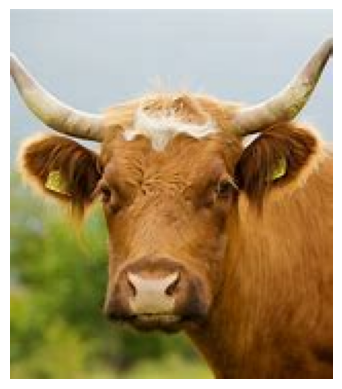

In [131]:
img = cv2.imread('images/image1.jpg', cv2.IMREAD_COLOR)
plt.imshow(img[:, :, ::-1]); plt.axis('off')

Now that we have our image, we can pass it through the network. To do this, we convert it into a blob using `blobfromImage`.

In [133]:
input_img = img.astype(np.float32)
 
input_img = cv2.resize(input_img, (256, 256))
 
# define preprocess parameters
mean = np.array([103.939, 116.779, 123.68])

# prepare input blob to fit the model input:
# subtract mean
input_blob = cv2.dnn.blobFromImage(
    image=img,
    size=(224, 224),  # img target size
    mean=mean,
    swapRB=True,  # BGR -> RGB
    crop=True  # center crop
)

The `mean`, `size` and `swapRB` are gotten from the model parameters, we do not come up with our own. Also, since the input blob is in NCHW order, we transpose it into NHWC to fit our model and then we can take a look at our image.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-123.68..151.061].


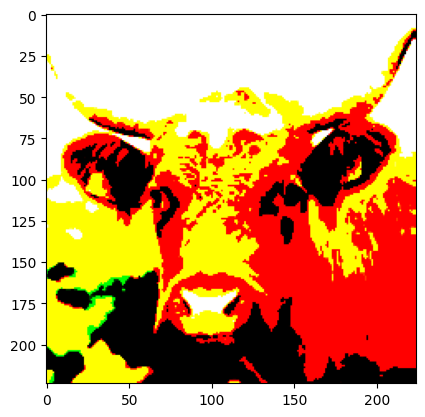

In [139]:
reshaped_blob = input_blob.transpose((0, 2, 3, 1))

plt.imshow(reshaped_blob.squeeze())

We can now run our prediction

In [140]:
resnet50.setInput(reshaped_blob)
preds = resnet50.forward()

Now that we have our predictions, the largest element in the predictions is the value we want. We can extract it.

In [141]:
classified = np.argmax(preds[0])

class_labels[classified]

'ox'

Text(0.5, 1.0, 'ox, 94.83 %')

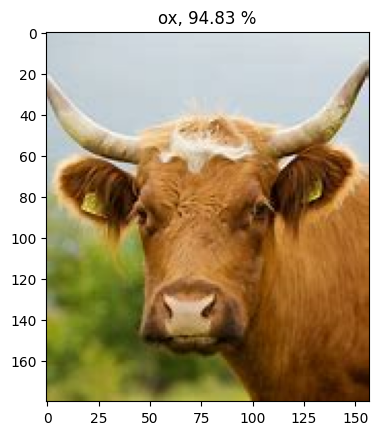

In [148]:
plt.imshow(img[:, :, ::-1]); plt.title(f'{class_labels[classified]}, {preds[0][classified] * 100:.2f} %')

## Extract Features From Final Layer

We can get outputs from any layer, not necessarily the top layer.

## Feature Extraction

(-0.5, 649.5, 424.5, -0.5)

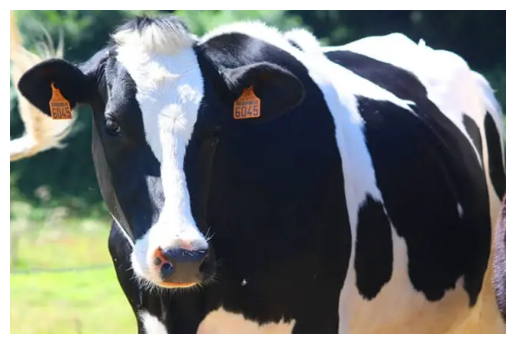

In [276]:
img2 = cv2.imread('images/image4.jpg', cv2.IMREAD_COLOR)
plt.imshow(img2[:, :, ::-1]); plt.axis('off')

In [320]:
img3 = cv2.imread('images/image2.jpg', cv2.IMREAD_COLOR)

In [321]:
input_blobs = cv2.dnn.blobFromImages(
    images=[img, img2, img3],
    size=(224, 224),  # img target size
    mean=mean,
    swapRB=True,  # BGR -> RGB
    crop=False  # center crop
)

In [363]:
layer_id = 123
layer_name = layers[layer_id]


reshaped_blobs = input_blobs.transpose((0, 2, 3, 1))
resnet50.setInput(reshaped_blobs)
reshape_output = resnet50.forward(layer_name)

print(resnet50.getLayer(layer_id).type)
reshape_output.squeeze().shape

Convolution


(3, 2048, 7, 7)

In [323]:
img1_pred = reshape_output[0]
img2_pred = reshape_output[1]
img3_pred = reshape_output[2]